torch.Size([60000, 28, 28])
torch.Size([60000])


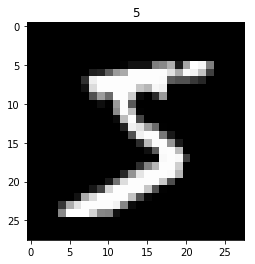

In [3]:
# library
# standard library
import os
 
# third-party library
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
 
torch.manual_seed(1)    # reproducible
 
# Hyper Parameters
EPOCH = 1               # train the training data n times, to save time, we just train 1 epoch
BATCH_SIZE = 50
LR = 0.001              # learning rate
DOWNLOAD_MNIST = False
 
# Mnist digits dataset
if not(os.path.exists('./mnist/')) or not os.listdir('./mnist/'):
    # not mnist dir or mnist is empyt dir
    DOWNLOAD_MNIST = True

train_data = torchvision.datasets.MNIST(
root='./mnist/',
train=True,                                     # this is training data
transform=torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                                # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
download=DOWNLOAD_MNIST,
)

# plot one example
print(train_data.train_data.size())                 # (60000, 28, 28)
print(train_data.train_labels.size())               # (60000)
plt.imshow(train_data.train_data[0].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[0])
plt.show()


In [19]:
import  dlc_practical_prologue as helper

In [78]:
train_input, train_target, train_classes, test_input, test_target, test_classes = helper.generate_pair_sets(1000)

In [79]:
train_input.size()

torch.Size([1000, 2, 14, 14])

In [43]:
train_classes[:][0]<train_classes[:][1]
for i, cl in enumerate(train_classes):
    if ((cl[0]<cl[1])!=train_target[i]):
        print(1)

RuntimeError: Expected object of scalar type Byte but got scalar type Long for argument #2 'other'

In [56]:
(cl[0]<cl[1]).int()==train_target[i]

RuntimeError: Expected object of scalar type Int but got scalar type Long for argument #2 'other'

In [167]:
train_loader

# CNN

和以前一样, 我们用一个 class 来建立 CNN 模型. 这个 CNN 整体流程是 卷积(Conv2d) -> 激励函数(ReLU) -> 池化, 向下采样 (MaxPooling) -> 再来一遍 -> 展平多维的卷积成的特征图 -> 接入全连接层 (Linear) -> 输出


In [203]:

# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
 
# convert test data into Variable, pick 2000 samples to speed up testing
# # 为了节约时间, 我们测试时只测试前2000个
test_data = torchvision.datasets.MNIST(root='./mnist/', train=False)
test_x = Variable(torch.unsqueeze(test_data.test_data, dim=1), volatile=True).type(torch.FloatTensor)[:2000]/255.   # shape from (2000, 28, 28) to (2000, 1, 28, 28), value in range(0,1)
test_y = test_data.test_labels[:2000]
 
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,              # input height
                out_channels=16,            # n_filters
                kernel_size=3,              # filter size
                stride=1                   # filter movement/step
                              # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 28, 28)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(kernel_size=3),    # choose max value in 2x2 area, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(         # input shape (16, 14, 14)
            nn.Conv2d(16, 32, 3 , 1, 1),     # output shape (32, 14, 14)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
        )
        self.out = nn.Linear(32 * 2 * 2, 10)   # fully connected layer, output 10 classes
 
    def forward(self, x):
        x = self.conv1(x)
#         print(x.size())
        x = self.conv2(x)
#         print(x.size())
        x = x.view(x.size(0), -1) 
#         print(x.size())# flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output, x    # return x for visualization
 
 
cnn = CNN()
print(cnn)  # net architecture

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=128, out_features=10, bias=True)
)


/Users/zhenchensu/anaconda2/envs/ada/lib/python3.5/site-packages/ipykernel/__main__.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


# Training


In [222]:
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted
 
# following function (plot_with_labels) is for visualization, can be ignored if not interested
from matplotlib import cm
try: from sklearn.manifold import TSNE; HAS_SK = True
except: HAS_SK = False; print('Please install sklearn for layer visualization')
def plot_with_labels(lowDWeights, labels):
    plt.cla()
    X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255 * s / 9)); plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.title('Visualize last layer'); plt.show(); plt.pause(0.01)

plt.ion()

mini_batch_size=100
# training and testing
EPOCH = 25
for epoch in range(EPOCH):
    for b in range(0, train_input.size(0), mini_batch_size):   # gives batch data, normalize x when iterate train_loader
        x = train_input.narrow(0, b, mini_batch_size)
        y = train_classes.narrow(0, b, mini_batch_size)
        x = x.narrow(1, 0, 1)
        y = y.narrow(1, 0, 1)
#         print(x.size(), y.size())
        b_x = Variable(x)   # batch x
        b_y = Variable(y)   # batch y
 
        output = cnn(b_x)[0]               # cnn output
#         print(output)
        b_y = b_y.squeeze()
        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients
 
        if step % 50 == 0:
            x_te = test_input.narrow(0, b, mini_batch_size).narrow(1, 0, 1)
            y_te = test_classes.narrow(0, b, mini_batch_size).narrow(1, 0, 1).squeeze()
            x_te = Variable(x_te)   # batch x
            y_te = Variable(y_te)   # batch y
        
            test_output, last_layer = cnn(x_te)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == y_te).sum().data.item() / y_te.size(0)
#             print(loss.data.item())
    print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.item(), '| test accuracy: %.2f' % accuracy)
#             if HAS_SK:
#                 # Visualization of trained flatten layer (T-SNE)
#                 tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
#                 plot_only = 500
#                 low_dim_embs = tsne.fit_transform(last_layer.data.numpy()[:plot_only, :])
#                 labels = test_y.numpy()[:plot_only]
#                 plot_with_labels(low_dim_embs, labels)
# plt.ioff()


Epoch:  0 | train loss: 0.1574 | test accuracy: 0.89
Epoch:  1 | train loss: 0.1769 | test accuracy: 0.91
Epoch:  2 | train loss: 0.1365 | test accuracy: 0.93
Epoch:  3 | train loss: 0.0654 | test accuracy: 0.95
Epoch:  4 | train loss: 0.0321 | test accuracy: 0.91
Epoch:  5 | train loss: 0.0322 | test accuracy: 0.94
Epoch:  6 | train loss: 0.0513 | test accuracy: 0.93
Epoch:  7 | train loss: 0.1408 | test accuracy: 0.91
Epoch:  8 | train loss: 0.0149 | test accuracy: 0.92
Epoch:  9 | train loss: 0.0438 | test accuracy: 0.93
Epoch:  10 | train loss: 0.0153 | test accuracy: 0.93
Epoch:  11 | train loss: 0.0106 | test accuracy: 0.93
Epoch:  12 | train loss: 0.0067 | test accuracy: 0.95
Epoch:  13 | train loss: 0.0053 | test accuracy: 0.94
Epoch:  14 | train loss: 0.0048 | test accuracy: 0.94
Epoch:  15 | train loss: 0.0046 | test accuracy: 0.94
Epoch:  16 | train loss: 0.0043 | test accuracy: 0.94
Epoch:  17 | train loss: 0.0041 | test accuracy: 0.94
Epoch:  18 | train loss: 0.0039 | test

In [215]:
y_te.shape

torch.Size([100])

In [192]:
train_x.shape

NameError: name 'train_x' is not defined

In [145]:
train_classes_ = torch.zeros(1000,2,10)
for i in range(train_classes.shape[0]):
    for j in range(train_classes.shape[1]):
        number = train_classes[i][j]
        train_classes_[j][i][number] = 1

In [170]:
train_classes.narrow()

torch.Size([1000, 2])

In [133]:
class Net(nn.Module):
    def __init__(self, nb_hidden):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(256, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 10)

    def forward(self, x):
#         print(x.size())
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=3, stride=3))
#         print(x.size())
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
#         print(x.size())
#         x = x.view(-1,256)
        x = F.relu(self.fc1(x.view(-1, 256)))
#         print(x.size())
        x = self.fc2(x)
#         print(x.size())
        return x

class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        nb_hidden = 200
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=2)
        self.fc1 = nn.Linear(9 * 64, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 1)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc1(x.view(-1, 9 * 64)))
        x = self.fc2(x)
        return x


In [151]:
def train_model(model, train_input, train_target, mini_batch_size):
    criterion = nn.MSELoss()
    eta = 1e-1

    for e in range(25):
        sum_loss = 0
        
        for b in range(0, train_input.size(0), mini_batch_size):
            output = model(train_input.narrow(0, b, mini_batch_size))
#             print(b, mini_batch_size)
#             print(train_target.narrow(0, b, mini_batch_size))
#             print(output)
            loss = criterion(output.float(), train_target.narrow(0, b, mini_batch_size).float())
            model.zero_grad()
            loss.backward()
            print(loss.item())
            sum_loss = sum_loss + loss.item()
            for p in model.parameters():
                p.data.sub_(eta * p.grad.data)
        print(e, sum_loss)

def compute_nb_errors(model, input, target, mini_batch_size):
    nb_errors = 0

    for b in range(0, input.size(0), mini_batch_size):
        output = model(input.narrow(0, b, mini_batch_size))
        _, predicted_classes = output.data.max(1)
        for k in range(mini_batch_size):
            if target.data[b + k, predicted_classes[k]] <= 0:
                nb_errors = nb_errors + 1

    return nb_errors

In [87]:
train_input, train_target = Variable(train_input), Variable(train_target)
test_input, test_target = Variable(test_input), Variable(test_target)

mini_batch_size = 100

In [153]:
from torch.nn import functional as F

for k in range(10):
    model = Net(200)
    train_model(model, train_input, train_target, mini_batch_size)
    nb_test_errors = compute_nb_errors(model, test_input, test_target, mini_batch_size)
    print('test error Net {:0.2f}% {:d}/{:d}'.format((100 * nb_test_errors) / test_input.size(0),
                                                      nb_test_errors, test_input.size(0)))


210.28598022460938
3.256977129636504e+22
inf
nan
nan
nan
nan
nan
nan
nan
0 nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
1 nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
2 nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
3 nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
4 nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
5 nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
6 nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
7 nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
8 nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
9 nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
10 nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
11 nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
12 nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
13 nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
14 nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
15 nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
16 nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
17 nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
18 nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
19 nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
n

IndexError: too many indices for tensor of dimension 1

torch.Size([100, 1, 14, 14])

In [154]:
class Model(torch.nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = torch.nn.Sequential(torch.nn.Conv2d(1,64,kernel_size=3,stride=1,padding=1),
                                         torch.nn.ReLU(),
                                         torch.nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
                                         torch.nn.ReLU(),
                                         torch.nn.MaxPool2d(stride=2,kernel_size=2))
        self.dense = torch.nn.Sequential(torch.nn.Linear(7*7*128,1024),
                                         torch.nn.ReLU(),
                                         torch.nn.Dropout(p=0.5),
                                         torch.nn.Linear(1024, 10))
    def forward(self, x):
        x = self.conv1(x)
        #x = self.conv2(x)
        x = x.view(-1, 7*7*128)
        x = self.dense(x)
        return x

In [156]:
train_input.size()

torch.Size([1000, 2, 14, 14])

In [160]:
train_classes.size()

torch.Size([1000, 2])

In [ ]:
cost = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
n_epochs = 5
mini_batch_size = 100

for epoch in range(n_epochs):
    running_loss = 0.0
    running_correct = 0
    print("Epoch {}/{}".format(epoch, n_epochs))
    print("-"*10)
    for b in range(0, train_input.size(0), mini_batch_size):
        X_train, y_train = train_input.narrow(0, b, mini_batch_size), train_classes_
        X_train, y_train = Variable(X_train), Variable(y_train)
        outputs = model(X_train)
        _,pred = torch.max(outputs.data, 1)
        optimizer.zero_grad()
        loss = cost(outputs, y_train)
        
        loss.backward()
        optimizer.step()
        running_loss += loss.data[0]
        running_correct += torch.sum(pred == y_train.data)
    testing_correct = 0
    for data in data_loader_test:
        X_test, y_test = data
        X_test, y_test = Variable(X_test), Variable(y_test)
        outputs = model(X_test)
        _, pred = torch.max(outputs.data, 1)
        testing_correct += torch.sum(pred == y_test.data)
    print("Loss is:{:.4f}, Train Accuracy is:{:.4f}%, Test Accuracy is:{:.4f}".format(running_loss/len(data_train),
                                                                                      100*running_correct/len(data_train),
                                                                                      100*testing_correct/len(data_test)))